In [1]:
import os
import numpy as np
import h5py
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import matplotlib.pyplot as plt

DATA_PATH = './IMAGE'
SIZE_X = 224  
SIZE_Y = 224  
N_CLASSES = 3 
BATCH_SIZE = 9
EPOCHS = 100
VAL_SPLIT = 0.2

# 1. توابع پیش‌پردازش -----------------------------------------------------------
def standardize(x):
    x = np.array(x, dtype='float32')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x = np.clip(x, 0, 1)
    return x

def preprocess_image_mask(img, mask):
    img = cv2.resize(img, (SIZE_X, SIZE_Y))
    img = standardize(img)
    img = np.expand_dims(img, axis=-1)  
    
    mask = cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
    mask = np.clip(mask, 0, 1)
    return img, mask

def load_dataset(data_path):
    images = []
    masks = []
    labels = []

    for file_name in tqdm(os.listdir(data_path)):
        if file_name.endswith('.mat'):
            with h5py.File(os.path.join(data_path, file_name), 'r') as f:
                cjdata = f['cjdata']
                img = np.array(cjdata['image']).astype('float32')
                mask = np.array(cjdata['tumorMask']).astype('float32')
                
                img, mask = preprocess_image_mask(img, mask)
                
                images.append(img)
                masks.append(mask)
                labels.append(int(np.array(cjdata['label']).flatten()[0]) - 1)

    return np.array(images), np.array(masks), np.array(labels)

print("Loading data...")
images, masks, labels = load_dataset(DATA_PATH)

masks_onehot = to_categorical(masks, num_classes=N_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(
    images, masks_onehot, 
    test_size=VAL_SPLIT, 
    random_state=42
)

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

def multi_unet_model(n_classes=3, IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # مسیر فشرده‌سازی
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(N_CLASSES, (1,1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
# change LE
model = multi_unet_model(n_classes=N_CLASSES, IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=1)
model.compile(optimizer=Adam(learning_rate=5e-4),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', jacard_coef, MeanIoU(num_classes=N_CLASSES)])
model.summary()


Loading data...


100%|██████████| 1155/1155 [00:06<00:00, 166.77it/s]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

Epoch 1/50
103/103 [==============================] - 22s 146ms/step - loss: 0.1324 - accuracy: 0.9645 - jacard_coef: 0.8983 - mean_io_u: 0.5821 - val_loss: 0.1918 - val_accuracy: 0.9841 - val_jacard_coef: 0.7387 - val_mean_io_u: 0.4850
Epoch 2/50
103/103 [==============================] - 12s 113ms/step - loss: 0.0499 - accuracy: 0.9851 - jacard_coef: 0.9513 - mean_io_u: 0.6783 - val_loss: 0.0939 - val_accuracy: 0.9738 - val_jacard_coef: 0.8642 - val_mean_io_u: 0.5378
Epoch 3/50
103/103 [==============================] - 12s 113ms/step - loss: 0.0399 - accuracy: 0.9871 - jacard_coef: 0.9596 - mean_io_u: 0.6928 - val_loss: 0.0745 - val_accuracy: 0.9734 - val_jacard_coef: 0.9000 - val_mean_io_u: 0.5657
Epoch 4/50
103/103 [==============================] - 12s 113ms/step - loss: 0.0353 - accuracy: 0.9892 - jacard_coef: 0.9649 - mean_io_u: 0.6835 - val_loss: 0.0496 - val_accuracy: 0.9866 - val_jacard_coef: 0.9273 - val_mean_io_u: 0.5470
Epoch 5/50
103/103 [==============================] 

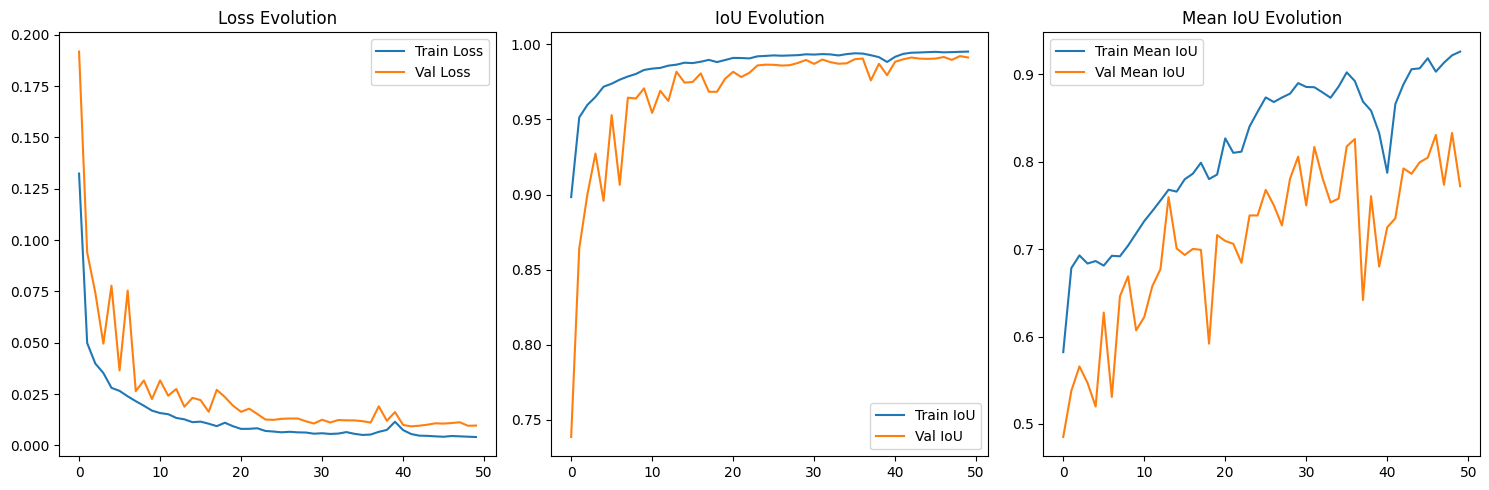

1/1 [==============================] - 1s 809ms/step


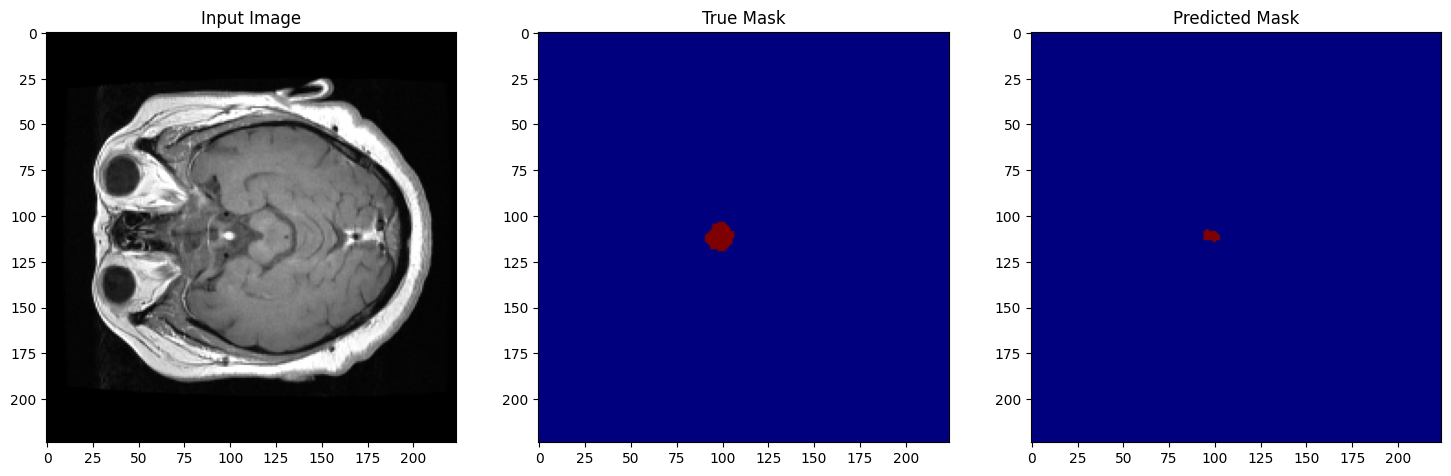

In [2]:
#change ephochs
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    verbose=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['jacard_coef'], label='Train IoU')
plt.plot(history.history['val_jacard_coef'], label='Val IoU')
plt.title('IoU Evolution')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u'], label='Train Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Val Mean IoU')
plt.title('Mean IoU Evolution')
plt.legend()

plt.tight_layout()
plt.show()

test_idx = np.random.randint(0, len(X_test))
test_img = X_test[test_idx]
test_mask = y_test[test_idx]
pred_mask = model.predict(test_img[np.newaxis, ...])[0]

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(np.argmax(pred_mask, axis=-1), cmap='jet')
plt.title('Predicted Mask')
plt.show()

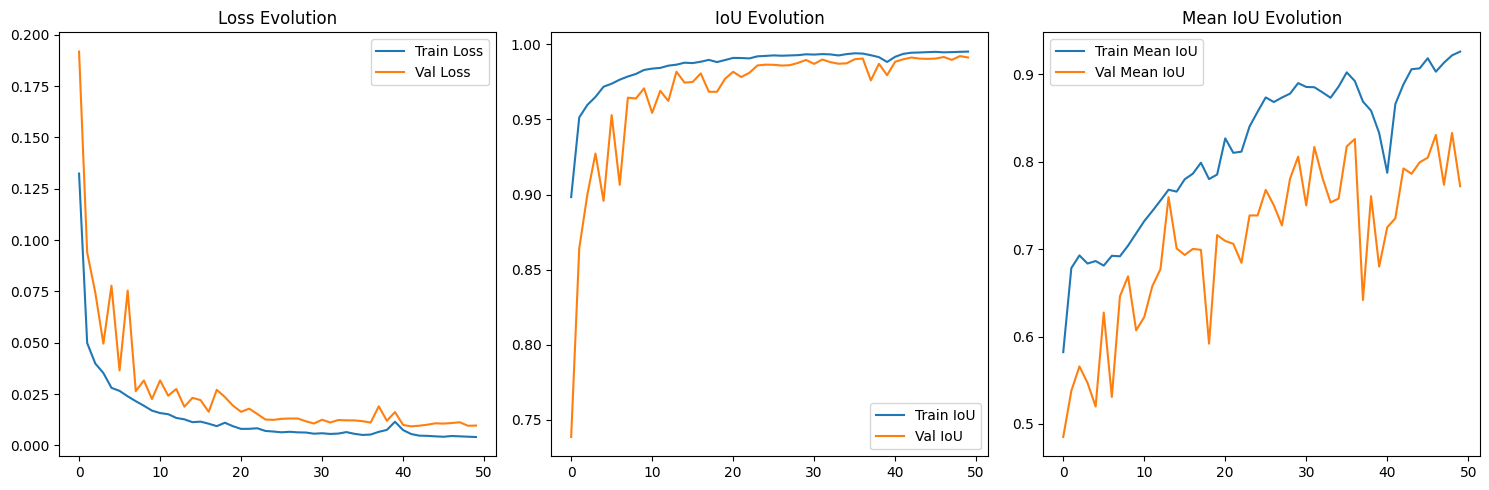

1/1 [==============================] - 0s 33ms/step


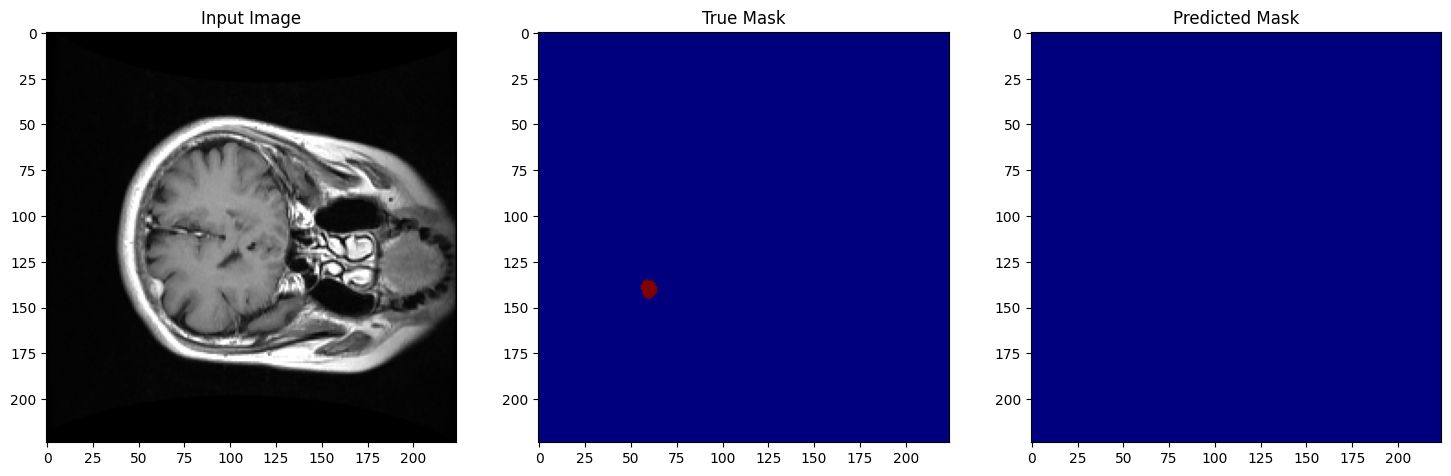

In [3]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['jacard_coef'], label='Train IoU')
plt.plot(history.history['val_jacard_coef'], label='Val IoU')
plt.title('IoU Evolution')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u'], label='Train Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Val Mean IoU')
plt.title('Mean IoU Evolution')
plt.legend()

plt.tight_layout()
plt.show()

test_idx = np.random.randint(0, len(X_test))
test_img = X_test[test_idx]
test_mask = y_test[test_idx]
pred_mask = model.predict(test_img[np.newaxis, ...])[0]

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(test_mask, axis=-1), cmap='jet')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(np.argmax(pred_mask, axis=-1), cmap='jet')
plt.title('Predicted Mask')
plt.show()